# GridSearchCV - Lab

## Introduction

In this lab, we'll explore how to use scikit-learn's `GridSearchCV` class to exhaustively search through every combination of hyperparameters until we find optimal values for a given model.

## Objectives

In this lab you will:

- Design a parameter grid for use with scikit-learn's GridSearchCV 
- Use GridSearchCV to increase model performance through parameter tuning 


## The dataset

For this lab, we'll be working with the [Wine Quality Dataset](https://archive.ics.uci.edu/ml/datasets/wine+quality) from the UCI Machine Learning dataset repository. We'll be using data about the various features of wine to predict the quality of the wine on a scale from 1-10 stars, making this a multiclass classification problem.  

### Getting started

Before we can begin grid searching our way to optimal hyperparameters, we'll need to go through the basic steps of modeling. This means that we'll need to:

* Import and inspect the dataset (and clean, if necessary)
* Split the data into training and test sets
* Build and fit a baseline model that we can compare against our grid search results 

Run the cell below to import everything we'll need for this lab:   

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score

Now that we've imported all the necessary libraries and functions for this lab, we'll need to get the dataset.  

Our data is stored in the file `'winequality-red.csv'`. Use Pandas to import the data from this file and store it in a DataFrame.  Print the head to ensure that everything loaded correctly. 

In [11]:
# Import the data
df = pd.read_csv('winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Great! Let's inspect our data. In the cell below, perform some basic exploratory data analysis on our dataset. Get a feel for your data by exploring the descriptive statistics and creating at least one visualization to help you better understand this dataset.

In [12]:
# Explore the dataset
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


<AxesSubplot:>

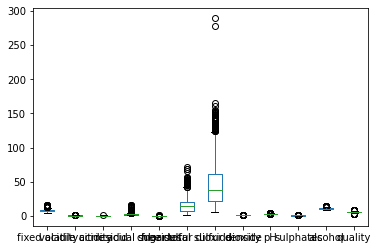

In [13]:
df.plot.box()

### Preprocessing our data

Now, we'll perform any necessary preprocessing on our dataset before training our model. We'll start by isolating the target variable that we are trying to predict.  

In the cell below: 
* Assign the data in the `quality` column to the `y` variable 
* Drop the `quality` column from the dataset and assign it to `X` 

In [14]:
y = df['quality']
X = df.drop('quality', axis = 1)
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


### Training, testing, and cross-validation

First we want to do a train-test split to create a holdout set to evaluate how good our final model is. Remember that any time we make modeling decisions based on a section of our data, we risk overfitting to that data. We can make use of **_Cross Validation_** when using `GridSearchCV` to do model selection and hyperparameter tuning, then test our final model choice on the test set.

In the cell below:

* Create a training and test set using `train_test_split()` (set `random_state=42` for reproducability)

In [15]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### Create a baseline model: Decision Trees

In the cell below: 

* Instantiate a `DecisionTreeClassifier`   
* Perform a 3-fold cross-validation on the training data using this classifier 
* Calculate and print the mean cross-validation score from the model 

**_Note:_** If you need a refresher on how to use `cross_val_score()`, check out the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). 

In [16]:
dt_clf = DecisionTreeClassifier()
dt_cv_score = cross_val_score(dt_clf, X_train, y_train, cv = 3)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")

Mean Cross Validation Score: 55.88%


Take a second to interpret the results of the cross-validation score.  How well did the model do? How does this compare to a naive baseline level of accuracy (random guessing)?

Write your answer below:

In [18]:
# Your answer here
# The model performed relatively poorly overall. It is, however, still much better than what would be
# expected form guessing (10%)

## Grid search: Decision trees

Our model does not have stellar performance. However, we've yet to modify the hyperparameters of the model. Each dataset is different, and the chances that the best possible parameters for a given dataset also happen to be the default parameters set by `scikit-learn` at instantiation is very low.  

This means that we need to try **_Hyperparameter Tuning_**.  There are several strategies for searching for optimal hyperparameters. The one we'll be using, **_Combinatoric Grid Searching_**, is probably the most popular because it performs an exhaustive search of all possible combinations.  

The sklearn module we'll be using to accomplish this is `GridSearchCV`, which can be found inside of `sklearn.model_selection`.

Take a minute to look at sklearn's user guide for [GridSearchCV](http://scikit-learn.org/stable/modules/grid_search.html#grid-search) and then complete the following task.

In the cell below:

* Complete the `param_grid` dictionary. In this dictionary, each key represents a parameter we want to tune and each corresponding value is a list of every parameter value we'd like to check for that parameter 
* Normally, you would have to just try different values to search through for each parameter.  However, in order to limit the complexity of this lab, the parameters and values to search through have been provided for you.  You just need to turn them into key-value pairs inside the `param_grid` dictionary. Complete `param_grid` so that it tests the following values for each corresponding parameter:
    * For `"criterion"`, try values of `"gini"` and `"entropy"` 
    * For `"max_depth"`, try `None`, as well as 2, 3, 4, 5, and 6  
    * For `min_samples_split`, try 2, 5, and 10 
    * For `"min_samples_leaf"`, try 1, 2, 3, 4, 5, and 6
    
* Before you run the grid search take some time to understand what each of the specific hyperparameters mean. How does varying the values of each hyperparameter effect the overfitting or underfitting of a decision tree model?

In [20]:
dt_param_grid = {
    'criterion': ['gini','entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

Now that we have our parameter grid set up, we can use `GridSearchCV`.  Before we do, let's briefly think about the particulars of this model. 

Grid Search works by training a model on the data for each unique combination of parameters and then returning the parameters of the model that performed best. In order to protect us from randomness, it is common to implement K-Fold cross-validation during this step.  For this lab, we'll set K = 3, meaning that we'll actually train 3 different models for each unique combination of parameters.  

Given our `param_grid` and the knowledge that we're going to use 3-fold cross-validation, how many different decision trees will `GridSearchCV` have to train in order to try every possible combination and find the best parameter choices?

Calculate and print your answer in the cell below.

In [25]:
from functools import reduce
num_decision_trees = reduce(lambda a, b: a*len(b), dt_param_grid.values(), 3)
print(f"Grid Search will have to search through {num_decision_trees} different permutations.")

Grid Search will have to search through 648 different permutations.


That's a lot of decision trees! Decision trees are generally pretty quick to train, but that isn't the case with every type of model we want to tune. Be aware that if you set a particularly large search space of parameters inside your parameter grid, then grid search could potentially take a very long time. 

Let's create our `GridSearchCV` object and fit it. In the cell below: 

* Instantiate `GridSearchCV`.  Pass in our model, the parameter grid, and `cv=3` to use 3-fold cross-validation. Also set `return_train_score` to `True` 
* Call our grid search object's `fit()` method and pass in our data and labels, just as if you were using regular cross validation  

In [26]:
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv = 3, return_train_score = True)

# Fit to the data
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True)

### Examine the best parameters

Now that we have fit our model using grid search, we need to inspect it to discover the optimal combination of parameters.

In the cell below:

* Calculate the the mean training score.  An array of training score results can be found inside the `.cv_results_` dictionary, with the key `mean_train_score` 
* Calculate the testing score using the our grid search model's `.score()` method by passing in our data and labels  
* Examine the appropriate attribute to discover the best estimator parameters found during the grid search  

**_HINT:_** If you're unsure what attribute this is stored in, take a look at sklearn's [GridSearchCV documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [33]:
# Mean training score
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])

# Mean test score
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 67.58%
Mean Test Score: 54.25%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

**_Question:_** What effect, if any, did our parameter tuning have on model performance? Will `GridSearchCV` always discover a perfectly (global) optimal set of parameters? Why or why not?

In [34]:
# Your answer here
# There's not much of an improvement. GridSearchCV doesn't always find the perfect parameter set, as it
# only checks the parameter values that we give it.

### Tuning more advanced models: Random forests

Now that we have some experience with grid searching through parameter values for a decision tree classifier, let's try our luck with a more advanced model and tune a _random forest classifier_.  

In the cell below:
* Instantiate a `RandomForestClassifier` 
* Use 3-fold cross-validation to generate a baseline score for this model type, so that we have something to compare our tuned model performance to 

In [36]:
rf_clf = RandomForestClassifier()
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, X_train, y_train, cv = 3))

print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}")

Mean Cross Validation Score for Random Forest Classifier: 65.31%


Now that we have our baseline score, we'll create a parameter grid specific to our random forest classifier.  

Again -- in a real world situation, you will need to decide what parameters to tune, and be very thoughtful about what values to test for each parameter.  However, since this is a lab, we have provided the following table in the interest of simplicity.  Complete the `rf_param_grid` dictionary with the following key-value pairs:
 
 
 |     Parameter     |         Values         |
|:-----------------:|:----------------------:|
|    n_estimators   |      [10, 30, 100]     |
|     criterion     |   ['gini', 'entropy']  |
|     max_depth     | [None, 2, 6, 10] |
| min_samples_split |       [5, 10]       |
|  min_samples_leaf |   [3, 6]   |

In [37]:
rf_param_grid = {
    'n_estimators':[10,30,100],
    'criterion':['gini','entropy'],
    'max_depth':[None, 2, 6, 10],
    'min_samples_split':[5,10],
    'min_samples_leaf':[3,6]
}

Great! Now that we have our parameter grid, we can grid search through it with our random forest. 

In the cell below, follow the process we used with decision trees above to grid search for the best parameters for our random forest classifier.  

Instantiate `GridSearchCV` and pass in:
* our random forest classifier
* the parameter grid 
* `cv=3` 
* **_do not_** specify `return_train_score` as we did with our decision trees example above.  In the interest of runtime, we'll only worry about testing accuracy this time  


**_NOTE:_** The runtime for the following cell can be over a minute on most computers.  

In [39]:
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv = 3)
rf_grid_search.fit(X_train, y_train)


print(f"Testing Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Testing Accuracy: 64.64%

Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}


### Interpret results 

Did tuning the hyperparameters of our random forest classifier improve model performance? Is this performance increase significant? Which model did better? If you had to choose, which model would you put into production? Explain your answer.

In [41]:
# Your answer here
# The improvement was non-existent. However, I would probably still choose the gridsearch version, as it
# is probably more consistent if I had to guess.

## Which model performed the best on the holdout set? 

Run the following cell to see the accuracy of the various grid search models on the test set: 

In [42]:
dt_score = dt_grid_search.score(X_test, y_test)
rf_score = rf_grid_search.score(X_test, y_test)

print('Decision tree grid search: ', dt_score)
print('Random forest grid search: ', rf_score)

Decision tree grid search:  0.5425
Random forest grid search:  0.645


So our random forest model performed the best! 

## Summary

In this lab, you learned to:

* iteratively search for optimal model parameters using `GridSearhCV`
* tune model parameters for decision trees and random forests models 